# 2020 SUMMER ESC :: Week 6 RNN

## LAB 11-4  RNN Time Series

- 시계열 분석?

시계열 분석은 관측지 $ x_1, x_2 ... x_n $가 시간적 순서를 가진 시계열 데이터에서 과거의 값을 통해 미래의 값을 예측하는 것이다. 시계열 분석을 위해 RNN 모델을 사용하고자 한다. 아래의 예시를 보자


![pic1.jpg](img/pic1.jpg) 

이 데이터는 일별 구글 주가데이터로, 시가 최고가 최저가 거래량 종가를 입력해 8일차의 종가를 예측하고자 한다. 이 모델은 8일차의 종가를 예측하기 위해서 그 전 일주일 치의 데이터를 보면 된다! 라는 가정을 하고 있다(실제와는 다른 가정..) 우리가 알고 있는 일반적인 시계열 분석의 경우 y변수를 trend, seasonality, noise로 나누어 예측을 하는 반면, RNN은 y변수 외에도 여러 feature들을 입력받아 값을 예측한다는 점에서 차이가 있다



**코드를 살펴보자!**


In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy[0]

array([8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
       8.31659973e+02])

- input data의 차원은 5
- 일주일 치의 데이터를 사용할 것이기 때문에 sequence의 길이는 7
- output dimension은 종가를 예측하는 것이기 때문에 1
- hidden layer의 경우 10으로 지정하고 있는데, input data를 받아서 하나의 값으로 압축을 해 다음 cell에 전달을 해주는 것은 모델에게 부담을 준다. 따라서 hidden layer의 차원을 충분히 보장해 주는 것

In [3]:
seq_length = 7    
data_dim = 5      
hidden_dim = 10   
output_dim = 1    
learning_rate = 0.01
iterations = 500

In [4]:
# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

In [5]:
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [6]:
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)    

- 각 feature의 값의 단위가 다르기 때문에 min-max scaling을 해준다. 학습에서 부담을 덜어줄 수 있다

In [7]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :] #7일치 데이터
        _y = time_series[i + seq_length, [-1]] #그 다음날의 종가 
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [8]:
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

In [9]:
print(trainX[0])

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]]


In [10]:
print(trainY[0])

[0.16053716]


In [11]:
# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [12]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1]) # OUTPUT에서 마지막 것만 사용하겠다. 이 값을 FC에 넣어서 예측값을 구한다 
        return x

In [13]:
net = Net(data_dim, hidden_dim, output_dim, 1)

In [14]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [15]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()

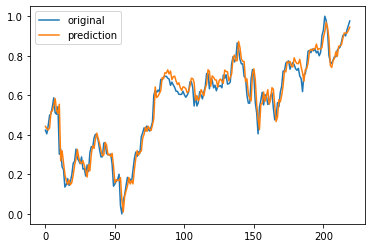

In [16]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()